# TESTING A PRE-TRAINED STATE-AUGMENTED MODEL
Load a pre-trained state-augmented model, experiment config and channel data. Run the test phase and plot metrics.

In [9]:
import json
import os
import glob
import torch
import re
import copy
import random
import tqdm
from collections import defaultdict
from matplotlib import pyplot as plt
import seaborn as sns
import time

In [10]:
# Load one pre-trained model and experiment results
save_path = 'visualization_results'
# experiment_root_path = "results/n_20_T_slices_{'train': 100, 'test': 500}_num_samples_{'train': 2, 'test': 1}/1700455656.290245 -- TEST VIOLATION RATES"
experiment_root_path = "results/n_20_T_slices_{'train': 100, 'test': 500}_num_samples_{'train': 16, 'test': 4}/1700457654.2167933 -- TEST VIOLATION RATES"


save_path = f'{save_path}/{experiment_root_path}'

experiment_name = re.search('results/(.+?)/', experiment_root_path).group(1)

# Load train chkpt
train_chkpt_root_path = f'{experiment_root_path}/train_chkpts/train_chkpt_'
file_type = r'*.pt'
files = glob.glob(train_chkpt_root_path + file_type)
latest_train_chkpt_path = max(files, key=os.path.getctime)
train_chkpt = torch.load(latest_train_chkpt_path)

# Load model chkpt
model_chkpt_root_path = f'{experiment_root_path}/train_chkpts/model_chkpt_'
file_type = r'*.pt'
files = glob.glob(model_chkpt_root_path + file_type)
latest_model_chkpt_path = max(files, key=os.path.getctime)
model_chkpt = torch.load(latest_model_chkpt_path)

# Load all epoch results chkpt
all_epoch_results_chkpt_root_path = f'{experiment_root_path}/train_chkpts/all_epoch_results_chkpt_'
file_type = r'*.pt'
files = glob.glob(all_epoch_results_chkpt_root_path + file_type)
latest_all_epoch_results_chkpt_path = max(files, key=os.path.getctime)
all_epoch_results_chkpt = torch.load(latest_all_epoch_results_chkpt_path)
# with open(latest_all_epoch_results_chkpt_path, 'r') as outfile:
#    all_epoch_results_chkpt = json.load(outfile)

In [11]:
from core.model import MLP
from core.Slice import Slice
from core.data_gen import create_data
from core.utils import make_test_configs, find_substring_index, seed_everything, make_experiment_name, create_network_configs,\
make_feature_extractor, make_constraint_fncs_and_lambda_samplers, make_eval_fnc, make_logger
from core.StateAugmentation import StateAugmentedSlicingAlgorithm

In [12]:
# How many more iterations do we want to run the pretrained model
n_epochs_more = 1

In [14]:
args = copy.deepcopy(train_chkpt['config'])
seed_everything(args.random_seed)

# create a string indicating the main experiment (hyper)parameters
experiment_name = make_experiment_name(args)
args.save_dir = experiment_root_path

args.channel_data_save_load_path = f'{args.root}/{args.save_dir}/channel_data'
args.traffic_data_save_load_path = f'{args.root}/{args.save_dir}/traffic_data'
    
# Create more folders and save the parsed configuration
os.makedirs(f'{save_path}', exist_ok=True)

# os.makedirs(f'{args.root}/results/{args.save_dir}/plots', exist_ok=True)
# os.makedirs(f'{args.root}/results/{args.save_dir}/train_chkpts', exist_ok=True)
# os.makedirs(f'{args.channel_data_save_load_path}', exist_ok=True)
# os.makedirs(f'{args.traffic_data_save_load_path}', exist_ok=True)
# with open(f'{args.root}/results/{args.save_dir}/config.json', 'w') as f:
#     json.dump(vars(args), f, indent = 6)

# Create network configs to initialize wireless networks
network_configs = create_network_configs(args)


# Change the constraint specifications
r_min_violation_rate = args.r_min_violation_rate # 0.05
l_max_violation_rate = args.l_max_violation_rate # 0.05
r_min = args.r_min
l_max = args.l_max

subpath = ''
if not r_min_violation_rate == args.r_min_violation_rate:
    subpath += f'_rate_violation_rate_{r_min_violation_rate}'
if not l_max_violation_rate == args.l_max_violation_rate:
    subpath += f'_latency_violation_rate_{l_max_violation_rate}'
if not r_min == args.r_min:
    subpath += f'_r_min_{r_min}'
if not l_max == args.l_max:
    subpath += f'_l_max_{l_max}'
if not subpath == '':
    subpath = '/' + subpath
print('Subpath: ', subpath)

args.r_min = r_min
args.l_max = l_max
args.r_min_violation_rate = r_min_violation_rate
args.l_max_violation_rate = l_max_violation_rate


# Create feature extractor, obj and constraint eval functions
feature_extractor, n_features = make_feature_extractor(['slice-weight', 'slice-avg-data-rate'], args)
obj = make_eval_fnc(eval_type = 'obj-mean-rate', eval_slices = [Slice.BE], args=args)

constraints, lambda_samplers = make_constraint_fncs_and_lambda_samplers(args)

args.num_features_list = [n_features + len(constraints)] + args.num_features_list[1:]

# set the computation device and create the model using a GNN parameterization
args.device = torch.device(args.device if torch.cuda.is_available() else 'cpu')
print('Device: ', args.device)
model = MLP(args.num_features_list, lambda_transform = args.lambda_transform, batch_norm = args.batch_norm).to(args.device)
model.load_state_dict(model_chkpt['model_state_dict'])
print('Model state dicts loaded...')

# Log print statements to a logs.txt file
loggers = [make_logger(f'{save_path}/logs.txt')]

# Load all epoch results
all_epoch_results = train_chkpt['all_epoch_results']
print('All epoch results loaded...')
print('The state-augmented model has been trained for {} epochs.'.format(len(all_epoch_results['train_state'])))

sa_learner = StateAugmentedSlicingAlgorithm(model=model,
                                            config=args,
                                            network_configs=network_configs,
                                            feature_extractor=feature_extractor,
                                            loggers=loggers,
                                            obj=obj,
                                            constraints=constraints,
                                            lambda_samplers = lambda_samplers,
                                            all_epoch_results=all_epoch_results)

Subpath:  
Device:  cuda:0
Model state dicts loaded...
All epoch results loaded...
The state-augmented model has been trained for 20 epochs.


In [7]:
# # Load model and instantiate state-augmented learner
# args.device = torch.device(args.device if torch.cuda.is_available() else 'cpu')
# model = GNN(args.num_features_list, args.P_max, dual_transform = args.dual_transform, batch_norm = args.batch_norm, dropout = args.dropout).to(args.device)
# model.load_state_dict(model_chkpt['model_state_dict'])
# print('Model state dicts loaded...')

# loggers = []
# plt_fncs = []

# # Create the state-augmented learner 
# all_epoch_results = train_chkpt['all_epoch_results']
# print('The state-augmented model has been trained for {} epochs'.format(len(all_epoch_results['train_metrics', 'primal'])))
# # print(all_epoch_results['train_metrics', 'primal'][-1].mu.shape)
# sa_learner = StateAugmentedLearner(model = model, config = args, train_dataloader = loader['train'], test_dataloader = loader['test'],
#                                     loggers = loggers, baseline_rates = baseline_rates,
#                                     all_epoch_results=all_epoch_results)

# # sa_learner.plot_test_evolution_over_timesteps(test_metrics_over_time_list,
# #                                                 save_path=save_path + '/plots/test_metrics_over_time/')

# # sa_learner.plot_test_lambdas_over_timesteps(test_metrics_over_time_list,
# #                                                 save_path=save_path + '/plots/test_lambdas_over_time/', graph_idx = range(min(10, args.num_samples['test'])))

# # sa_learner.plot_test_evolution_over_epochs(test_metrics_list,
# #                                                  save_path=save_path + '/plots/test_evolution/')
# # sa_learner.plot_test_evolution_over_epochs([test_metrics for _ in test_configs],
# #                                                  save_path=save_path + '/plots/test_evolution/')

Model state dicts loaded...
The state-augmented model has been trained for 20 epochs


## Run Dual Estimation Procedure

In [8]:
n_iters = 20
n_trajectories = 10
T_dual_optim = 2000 # ergodicity
lr_dual_optim = 0.05
alpha = 0.9
alpha_step = 0.2 # None
alpha_grow_period = 5 # None
T_0_dual_optim = 5 
mu_avg_warmup_t_frac = 0.5

sa_learner.config.dual_train_dist_update_n_iters = n_iters
sa_learner.config.dual_train_dist_update_n_trajectories = n_trajectories
sa_learner.config.T_dual_optim = T_dual_optim
sa_learner.config.lr_dual_train_dist = alpha
sa_learner.config.lr_dual['train'] = lr_dual_optim # lr_dual_optim
sa_learner.config.dual_clamp_max = sa_learner.config.dual_train_dist_mean + sa_learner.config.dual_train_dist_sigma
sa_learner.config.T['train'] = T_0_dual_optim # update window in dual dynamics
sa_learner.config.mu_avg_warmup_t_frac = mu_avg_warmup_t_frac
print('dual clamp max:', sa_learner.config.dual_clamp_max)

dual_optim_config = f'T_dual_optim_{sa_learner.config.T_dual_optim}_n_iters_{sa_learner.config.dual_train_dist_update_n_iters}_n_trajectories_{sa_learner.config.dual_train_dist_update_n_trajectories}_lr_dual_optim_{lr_dual_optim}/'

print('Running dual estimation...')
sa_learner.all_epoch_results['train', 'dual_optim_estimation'] = []
sa_learner.all_epoch_results['train', 'dual_optim_all_mu_over_time'] = []
sa_learner.all_epoch_results['train', 'dual_optim_all_constraint_slacks_over_time'] = []
sa_learner.all_epoch_results['train', 'dual_optim_estimation_error'] = defaultdict(list)
all_dual_optim_estimation_errors = defaultdict(list)

# sa_learner.dual_optim_state = sa_learner.dual_optim_state._replace(mu = torch.zeros_like(sa_learner.dual_optim_state.mu))
for iter in tqdm.tqdm(range(sa_learner.config.dual_train_dist_update_n_iters)):
    # tune the learning rate
    if alpha_grow_period is not None and alpha_step is not None and (iter + 1) % alpha_grow_period == 0:
        alpha += alpha_step
        alpha = max(0, min(1, alpha))

        sa_learner.config.lr_dual_train_dist = alpha

    sa_learner.dual_optim_state, dual_optim_err = sa_learner.dual_step(force_dual_step = True, compute_estimation_error = True) # estimate optimal dual multipliers
    if sa_learner.dual_optim_state.mu_over_time is None:
        break

    for key,value in dual_optim_err.items():
        all_dual_optim_estimation_errors[key].append(value)
    
    sa_learner.all_epoch_results['train', 'dual_optim_estimation'].append(sa_learner.dual_optim_state.mu.detach().cpu().numpy())

    # Store all constraint slacks and dual multipliers across different realizations
    dual_optim_all_mu_over_time = sa_learner.dual_optim_state.mu_over_time.reshape(sa_learner.config.dual_train_dist_update_n_trajectories, -1, *sa_learner.dual_optim_state.mu_over_time.shape[1:])
    dual_optim_all_constraint_slacks_over_time = sa_learner.dual_optim_state.constraints_over_time.reshape(sa_learner.config.dual_train_dist_update_n_trajectories, -1, *sa_learner.dual_optim_state.constraints_over_time.shape[1:])
    sa_learner.all_epoch_results['train', 'dual_optim_all_mu_over_time'].append(dual_optim_all_mu_over_time)
    sa_learner.all_epoch_results['train', 'dual_optim_all_constraint_slacks_over_time'].append(dual_optim_all_constraint_slacks_over_time)

sa_learner.all_epoch_results['train', 'dual_optim_estimation_error'] = all_dual_optim_estimation_errors
print('Dual estimation complete...')

dual clamp max: 5.0
Running dual estimation...


  0%|          | 0/20 [00:00<?, ?it/s]

Dual multiplier estimation average L_2 error: 0.1254824846982956, 	 average L_inf error: 0.12764227390289307 	 Max L_inf error: 1.282132863998413
Dual multiplier estimation average L_2 error: 0.14240701496601105, 	 average L_inf error: 0.14120090007781982 	 Max L_inf error: 1.8098121881484985
Dual multiplier estimation average L_2 error: 0.0971844494342804, 	 average L_inf error: 0.1400652974843979 	 Max L_inf error: 0.9900038838386536
Dual multiplier estimation average L_2 error: 1.4831527471542358, 	 average L_inf error: 0.2554645836353302 	 Max L_inf error: 8.810660362243652


  5%|▌         | 1/20 [01:31<29:01, 91.66s/it]

Dual multiplier estimation average L_2 error: 0.007408766075968742, 	 average L_inf error: 0.018398426473140717 	 Max L_inf error: 0.35652732849121094
Dual multiplier estimation average L_2 error: 0.027325714007019997, 	 average L_inf error: 0.035557329654693604 	 Max L_inf error: 1.1513574123382568
Dual multiplier estimation average L_2 error: 1.6090868711471558, 	 average L_inf error: 0.17248016595840454 	 Max L_inf error: 10.137567520141602
Dual multiplier estimation average L_2 error: 0.0008320491178892553, 	 average L_inf error: 0.013460912741720676 	 Max L_inf error: 0.08930525183677673


 10%|█         | 2/20 [03:04<27:47, 92.62s/it]

Dual multiplier estimation average L_2 error: 0.0018692838493734598, 	 average L_inf error: 0.013300465419888496 	 Max L_inf error: 0.2089378833770752
Dual multiplier estimation average L_2 error: 1.7272400856018066, 	 average L_inf error: 0.18648800253868103 	 Max L_inf error: 10.454057693481445
Dual multiplier estimation average L_2 error: 0.0003274395130574703, 	 average L_inf error: 0.009396985173225403 	 Max L_inf error: 0.057720720767974854
Dual multiplier estimation average L_2 error: 0.001843215781264007, 	 average L_inf error: 0.01708248257637024 	 Max L_inf error: 0.19945505261421204


 15%|█▌        | 3/20 [04:34<25:53, 91.40s/it]

Dual multiplier estimation average L_2 error: 0.02043176256120205, 	 average L_inf error: 0.027930747717618942 	 Max L_inf error: 1.031515121459961
Dual multiplier estimation average L_2 error: 0.005424560979008675, 	 average L_inf error: 0.019548121839761734 	 Max L_inf error: 0.32815253734588623
Dual multiplier estimation average L_2 error: 0.0027445373125374317, 	 average L_inf error: 0.010898524895310402 	 Max L_inf error: 0.23647642135620117
Dual multiplier estimation average L_2 error: 1.8529865741729736, 	 average L_inf error: 0.17836742103099823 	 Max L_inf error: 10.888157844543457


 20%|██        | 4/20 [06:07<24:30, 91.89s/it]

Dual multiplier estimation average L_2 error: 1.8857669830322266, 	 average L_inf error: 0.18107976019382477 	 Max L_inf error: 10.983942031860352
Dual multiplier estimation average L_2 error: 0.05400209501385689, 	 average L_inf error: 0.039690859615802765 	 Max L_inf error: 1.8395414352416992
Dual multiplier estimation average L_2 error: 0.001019122893922031, 	 average L_inf error: 0.011382393538951874 	 Max L_inf error: 0.1209772527217865
Dual multiplier estimation average L_2 error: 0.00329765398055315, 	 average L_inf error: 0.017220009118318558 	 Max L_inf error: 0.2804691791534424


 25%|██▌       | 5/20 [07:40<23:02, 92.17s/it]

Dual multiplier estimation average L_2 error: 1.9572467803955078, 	 average L_inf error: 0.18920841813087463 	 Max L_inf error: 11.186336517333984
Dual multiplier estimation average L_2 error: 0.03005116432905197, 	 average L_inf error: 0.030928175896406174 	 Max L_inf error: 1.379136085510254
Dual multiplier estimation average L_2 error: 0.0004935396136716008, 	 average L_inf error: 0.011491728015244007 	 Max L_inf error: 0.07191887497901917
Dual multiplier estimation average L_2 error: 0.0008469540625810623, 	 average L_inf error: 0.009025581181049347 	 Max L_inf error: 0.15721642971038818


 30%|███       | 6/20 [09:13<21:37, 92.70s/it]

Dual multiplier estimation average L_2 error: 0.0010696535464376211, 	 average L_inf error: 0.009847920387983322 	 Max L_inf error: 0.17075204849243164
Dual multiplier estimation average L_2 error: 0.0007392448605969548, 	 average L_inf error: 0.010055525228381157 	 Max L_inf error: 0.0901188850402832
Dual multiplier estimation average L_2 error: 1.6213722229003906, 	 average L_inf error: 0.16992703080177307 	 Max L_inf error: 10.182438850402832
Dual multiplier estimation average L_2 error: 0.061439674347639084, 	 average L_inf error: 0.04439553990960121 	 Max L_inf error: 1.9510383605957031


 35%|███▌      | 7/20 [10:47<20:08, 92.95s/it]

Dual multiplier estimation average L_2 error: 0.0013458299217745662, 	 average L_inf error: 0.012148336507380009 	 Max L_inf error: 0.1284458041191101
Dual multiplier estimation average L_2 error: 0.0020397354383021593, 	 average L_inf error: 0.014306116849184036 	 Max L_inf error: 0.23998266458511353
Dual multiplier estimation average L_2 error: 0.00017916958313435316, 	 average L_inf error: 0.0063007427379488945 	 Max L_inf error: 0.054554253816604614
Dual multiplier estimation average L_2 error: 1.6875531673431396, 	 average L_inf error: 0.19671761989593506 	 Max L_inf error: 10.261881828308105


 40%|████      | 8/20 [12:19<18:31, 92.61s/it]

Dual multiplier estimation average L_2 error: 0.024666426703333855, 	 average L_inf error: 0.03050922602415085 	 Max L_inf error: 1.2253022193908691
Dual multiplier estimation average L_2 error: 0.00015552456898149103, 	 average L_inf error: 0.0065774619579315186 	 Max L_inf error: 0.03909143805503845
Dual multiplier estimation average L_2 error: 0.0006243117968551815, 	 average L_inf error: 0.01017356850206852 	 Max L_inf error: 0.10829931497573853
Dual multiplier estimation average L_2 error: 1.601938009262085, 	 average L_inf error: 0.17205694317817688 	 Max L_inf error: 10.116808891296387


 45%|████▌     | 9/20 [13:53<17:02, 92.96s/it]

Dual multiplier estimation average L_2 error: 1.6921415328979492, 	 average L_inf error: 0.17319577932357788 	 Max L_inf error: 10.404504776000977
Dual multiplier estimation average L_2 error: 0.011388557031750679, 	 average L_inf error: 0.01815848797559738 	 Max L_inf error: 0.830327033996582
Dual multiplier estimation average L_2 error: 0.001801058417186141, 	 average L_inf error: 0.013672737404704094 	 Max L_inf error: 0.2616211771965027
Dual multiplier estimation average L_2 error: 0.0011016224743798375, 	 average L_inf error: 0.009839353151619434 	 Max L_inf error: 0.16145628690719604


 50%|█████     | 10/20 [15:26<15:30, 93.03s/it]

Dual multiplier estimation average L_2 error: 0.012562492862343788, 	 average L_inf error: 0.022939208894968033 	 Max L_inf error: 0.8649134635925293
Dual multiplier estimation average L_2 error: 0.0001523675164207816, 	 average L_inf error: 0.006898934952914715 	 Max L_inf error: 0.03448803722858429
Dual multiplier estimation average L_2 error: 0.0019166633719578385, 	 average L_inf error: 0.013255689293146133 	 Max L_inf error: 0.1414426565170288
Dual multiplier estimation average L_2 error: 1.8967556953430176, 	 average L_inf error: 0.1815667599439621 	 Max L_inf error: 11.014625549316406


 55%|█████▌    | 11/20 [16:59<13:58, 93.19s/it]

Dual multiplier estimation average L_2 error: 0.0006333388737402856, 	 average L_inf error: 0.009245796129107475 	 Max L_inf error: 0.10845863819122314
Dual multiplier estimation average L_2 error: 0.0012250487925484776, 	 average L_inf error: 0.010008026845753193 	 Max L_inf error: 0.21844744682312012
Dual multiplier estimation average L_2 error: 0.013629136607050896, 	 average L_inf error: 0.02514820173382759 	 Max L_inf error: 0.9052176475524902
Dual multiplier estimation average L_2 error: 1.9212487936019897, 	 average L_inf error: 0.18296097218990326 	 Max L_inf error: 11.085926055908203


 60%|██████    | 12/20 [18:31<12:21, 92.74s/it]

Dual multiplier estimation average L_2 error: 0.023843122646212578, 	 average L_inf error: 0.028681311756372452 	 Max L_inf error: 1.164492130279541
Dual multiplier estimation average L_2 error: 1.9933953285217285, 	 average L_inf error: 0.1846950799226761 	 Max L_inf error: 11.290491104125977
Dual multiplier estimation average L_2 error: 0.0007791438256390393, 	 average L_inf error: 0.011987227946519852 	 Max L_inf error: 0.07075047492980957
Dual multiplier estimation average L_2 error: 0.00019009712559636682, 	 average L_inf error: 0.008112268522381783 	 Max L_inf error: 0.03868985176086426


 65%|██████▌   | 13/20 [20:04<10:49, 92.83s/it]

Dual multiplier estimation average L_2 error: 0.0009538421873003244, 	 average L_inf error: 0.010423352010548115 	 Max L_inf error: 0.14298880100250244
Dual multiplier estimation average L_2 error: 0.0006564721115864813, 	 average L_inf error: 0.011747542768716812 	 Max L_inf error: 0.10873597860336304
Dual multiplier estimation average L_2 error: 1.9344778060913086, 	 average L_inf error: 0.18109822273254395 	 Max L_inf error: 11.125123977661133
Dual multiplier estimation average L_2 error: 0.03591170534491539, 	 average L_inf error: 0.0346766822040081 	 Max L_inf error: 1.4951934814453125


 70%|███████   | 14/20 [21:35<09:13, 92.33s/it]

Dual multiplier estimation average L_2 error: 0.00013099063653498888, 	 average L_inf error: 0.005313057452440262 	 Max L_inf error: 0.038043200969696045
Dual multiplier estimation average L_2 error: 1.6640582084655762, 	 average L_inf error: 0.1738395392894745 	 Max L_inf error: 10.31583309173584
Dual multiplier estimation average L_2 error: 0.014155169017612934, 	 average L_inf error: 0.033147770911455154 	 Max L_inf error: 0.8225283622741699
Dual multiplier estimation average L_2 error: 0.0001851656415965408, 	 average L_inf error: 0.006365290377289057 	 Max L_inf error: 0.07642167806625366


 75%|███████▌  | 15/20 [23:06<07:38, 91.73s/it]

Dual multiplier estimation average L_2 error: 0.00021481740986928344, 	 average L_inf error: 0.007526956032961607 	 Max L_inf error: 0.06463107466697693
Dual multiplier estimation average L_2 error: 1.7846767902374268, 	 average L_inf error: 0.1952376663684845 	 Max L_inf error: 10.615490913391113
Dual multiplier estimation average L_2 error: 0.0015807717572897673, 	 average L_inf error: 0.01333482377231121 	 Max L_inf error: 0.2231534719467163
Dual multiplier estimation average L_2 error: 0.000738324539270252, 	 average L_inf error: 0.008913797326385975 	 Max L_inf error: 0.1422175168991089


 80%|████████  | 16/20 [24:36<06:04, 91.25s/it]

Dual multiplier estimation average L_2 error: 0.0006807114696130157, 	 average L_inf error: 0.010575979016721249 	 Max L_inf error: 0.10624295473098755
Dual multiplier estimation average L_2 error: 1.7005841732025146, 	 average L_inf error: 0.1882413774728775 	 Max L_inf error: 10.37595272064209
Dual multiplier estimation average L_2 error: 0.0004489910788834095, 	 average L_inf error: 0.008025070652365685 	 Max L_inf error: 0.0920330137014389
Dual multiplier estimation average L_2 error: 0.005481932312250137, 	 average L_inf error: 0.017758462578058243 	 Max L_inf error: 0.3497018814086914


 85%|████████▌ | 17/20 [26:07<04:33, 91.14s/it]

Dual multiplier estimation average L_2 error: 0.00020709412638098001, 	 average L_inf error: 0.00703610572963953 	 Max L_inf error: 0.0467037558555603
Dual multiplier estimation average L_2 error: 0.00040744541911408305, 	 average L_inf error: 0.00856873206794262 	 Max L_inf error: 0.06737709045410156
Dual multiplier estimation average L_2 error: 0.005859652534127235, 	 average L_inf error: 0.01779920607805252 	 Max L_inf error: 0.5962557792663574
Dual multiplier estimation average L_2 error: 1.7485835552215576, 	 average L_inf error: 0.1760234385728836 	 Max L_inf error: 10.576472282409668


 90%|█████████ | 18/20 [27:37<03:01, 90.93s/it]

Dual multiplier estimation average L_2 error: 0.00046671449672430754, 	 average L_inf error: 0.008578486740589142 	 Max L_inf error: 0.07772666215896606
Dual multiplier estimation average L_2 error: 1.6435378789901733, 	 average L_inf error: 0.16762258112430573 	 Max L_inf error: 10.253920555114746
Dual multiplier estimation average L_2 error: 0.01020018756389618, 	 average L_inf error: 0.025472771376371384 	 Max L_inf error: 0.7667198181152344
Dual multiplier estimation average L_2 error: 0.0004916150937788188, 	 average L_inf error: 0.00992328580468893 	 Max L_inf error: 0.06591251492500305


 95%|█████████▌| 19/20 [29:10<01:31, 91.51s/it]

Dual multiplier estimation average L_2 error: 0.005783321801573038, 	 average L_inf error: 0.017967600375413895 	 Max L_inf error: 0.5530295372009277
Dual multiplier estimation average L_2 error: 0.0006279753870330751, 	 average L_inf error: 0.009594494476914406 	 Max L_inf error: 0.10690134763717651
Dual multiplier estimation average L_2 error: 0.002095509087666869, 	 average L_inf error: 0.013196245767176151 	 Max L_inf error: 0.280120313167572
Dual multiplier estimation average L_2 error: 1.8367643356323242, 	 average L_inf error: 0.1766788512468338 	 Max L_inf error: 10.840582847595215


100%|██████████| 20/20 [30:42<00:00, 92.12s/it]

Dual estimation complete...


In [9]:
import numpy as np
def threshold_multipliers(lambdas, thresh_low = 0.0, thresh_high = None):

    n_graphs, n, n_mixtures = lambdas.shape
    if thresh_high is None:
        temp_graph_idx, temp_client_idx = np.where(lambdas[:, :, 0] >= thresh_low)
    else:
        temp_graph_idx, temp_client_idx = np.where((lambdas[:, :, 0] >= thresh_low) * (lambdas[:, :, 0] <= thresh_high))

    graph_idx = np.unique(temp_graph_idx)
    client_idx = [[] for _ in range(len(graph_idx))]
    for idx, graph in enumerate(graph_idx):
        client_idx[idx] = temp_client_idx[np.where(temp_graph_idx == graph_idx[idx])].tolist()

    return graph_idx, client_idx

In [45]:
graph_idx, client_idx = threshold_multipliers(sa_learner.all_epoch_results['train', 'dual_optim_estimation'][-1], thresh_low = 0.6)
print('Plot networks #', graph_idx)
print('Plot clients # ', client_idx)

Plot networks # [ 37  59  79 126 167 198 244]
Plot clients #  [[1, 3, 4], [0, 1, 2, 3, 4], [1, 2], [2], [0, 4], [0, 1, 2, 3, 4], [3]]


## Plot dual optimization metrics

In [19]:
def unique(list1):
    # insert the list to the set
    list_set = set(list1)
    # convert the set to the list
    unique_list = (list(list_set))
    return unique_list


# Plot everything about dual optimization step
if sa_learner.dual_optim_state.mu_over_time is not None:
    # sa_learner.plot_train_dual_optim_evolution_over_timesteps(sa_learner.dual_optim_state, save_path=save_path + '/plots/train_dual_optim_evolution/', graph_idx = graph_idx)
    sa_learner.plot_train_dual_optim_estimation_error_evolution_over_dual_iters(sa_learner.all_epoch_results['train', 'dual_optim_estimation_error'],
                                                                            save_path = save_path + f'/plots/train_dual_optim_estimation_error_evolution_over_dual_iters/{dual_optim_config}')
    sa_learner.plot_train_dual_optim_hist(sa_learner.dual_optim_state,
                                            save_path = save_path + f'/plots/train_dual_optim_hist/{dual_optim_config}')
    sa_learner.plot_train_dual_optim_estimation_evolution_over_dual_iters(sa_learner.all_epoch_results['train', 'dual_optim_estimation'],
                                                                            save_path = save_path + f'/plots/train_dual_optim_estimation_evolution_over_dual_iters/{dual_optim_config}',
                                                                            graph_idx = graph_idx,
                                                                            client_idx = client_idx)

    dual_optim_plot_subiters = unique([0,
                                max(0, len(sa_learner.all_epoch_results['train', 'dual_optim_all_mu_over_time']) // 4 - 1),
                                max(0, len(sa_learner.all_epoch_results['train', 'dual_optim_all_mu_over_time']) // 2 - 1),
                                max(0, len(sa_learner.all_epoch_results['train', 'dual_optim_all_mu_over_time'])-1)]
                                ) # first and last dual optim subiters
    for subiter in dual_optim_plot_subiters:
        sa_learner.plot_train_dual_optim_estimation_evolution_over_timesteps(sa_learner.all_epoch_results['train', 'dual_optim_all_mu_over_time'][subiter],
                                                                                sa_learner.all_epoch_results['train', 'dual_optim_all_constraint_slacks_over_time'][subiter],
                                                                                save_path=save_path + f'/plots/train_dual_optim_estimation_evolution_over_timesteps/{dual_optim_config}',
                                                                                dual_iter=subiter,
                                                                                graph_idx = graph_idx,
                                                                                client_idx = client_idx)

In [14]:
# Postprocess optimal multiplier estimates
dual_estimation_chkpt_save_path = save_path + f'/dual_estimation_chkpt/{dual_optim_config}'
os.makedirs(dual_estimation_chkpt_save_path, exist_ok=True)


optimal_lambdas_orig = np.copy(sa_learner.all_epoch_results['train', 'dual_optim_estimation'][-1])
graph_idx, client_idx = threshold_multipliers(optimal_lambdas_orig, thresh_low = sa_learner.config.dual_clamp_max)

optimal_lambdas = optimal_lambdas_orig
for gidx in graph_idx:
    for cidx in client_idx:
        optimal_lambdas[gidx, cidx] = np.nan 

print('Number of diverging optimal multipliers: ', np.isnan(optimal_lambdas).sum())

# save optimal lambdas for dual regression
with open(f'{dual_estimation_chkpt_save_path}dual_estimates.npy', 'wb') as f:
    np.save(f, optimal_lambdas)

Number of diverging optimal multipliers:  4


## Train a DualRegressor
We will train a dualRegressor. Before that, let's visualize the optimal multipliers vs. SINR.

In [15]:
# Load optimal multipliers
dual_estimation_chkpt_load_path = dual_estimation_chkpt_save_path
with open(f'{dual_estimation_chkpt_load_path}dual_estimates.npy', 'rb') as f:
    optimal_lambdas = np.load(f)

In [43]:
from utils import calc_rates

def get_log_SINR_features(sa_learner):
    all_log_sinr = torch.zeros(sa_learner.config.num_samples['train'], sa_learner.config.n, max(sa_learner.config.T['train'], sa_learner.config.T['test']), dtype=torch.float32, device=sa_learner.config.device)
    hl_log_sinr = torch.zeros_like(all_log_sinr[:, :, 0])
    for batch_idx, data in enumerate(sa_learner.train_dataloader):
        sample_idx = data[1]
        data = data[0].to(sa_learner.config.device)

        y, edge_index_l, edge_weight_l, edge_index, \
        edge_weight, a, a_l, transmitters_index, num_graphs = \
            data.y, data.edge_index_l, data.edge_weight_l, data.edge_index, data.edge_weight, \
            data.weighted_adjacency, data.weighted_adjacency_l, \
            data.transmitters_index, data.num_graphs   

        num_graphs = data.num_graphs
        n = data.transmitters_index.numel() // num_graphs
        T = len(edge_index)

        log_sinr_over_time = []
        for t in range(T):

            # Compute SINR levels under full power transmission scenario
            p = torch.ones(num_graphs * n).view(-1).to(sa_learner.config.device)
            gamma = torch.ones(num_graphs * n, 1).to(sa_learner.config.device)
            log_sinr = calc_rates(p, gamma, a[:, :, :, t], sa_learner.config.noise_var).view(-1, n)
            log_sinr_over_time.append(log_sinr)

        log_sinr_over_time = torch.stack(log_sinr_over_time, dim = -1)
        all_log_sinr[sample_idx] = log_sinr_over_time.clone()
        hl_log_sinr[sample_idx] = calc_rates(p, gamma, a_l, sa_learner.config.noise_var).view(-1, n)
        

    return all_log_sinr.detach().cpu().numpy(), hl_log_sinr.unsqueeze(-1).detach().cpu().numpy()


# plt.rcParams.update({'font.size': 8})
plt.rcParams['patch.edgecolor'] = 'none'
# plt.rcParams['figure.figsize'] = (18, 6)
FIG_ROWSIZE = 6
FIG_COLSIZE = 6
FIG_FONTSIZE = 8

sns.set_style('darkgrid')
plt.rcParams.update({'font.size': 14})

def scatter_plot_dual_multipliers_sinr_features(lambdas, sinr_features, **kwargs):
    fig_rowSize = kwargs.get('fig_rowSize', FIG_ROWSIZE)
    fig_colSize = kwargs.get('fig_colSize', FIG_COLSIZE)
    fig_fontSize = kwargs.get('fig_fontSize', FIG_FONTSIZE)
    fig_title = kwargs.get('title', None)

    for dim in range(sinr_features.ndim):
        if not lambdas.shape[dim] == sinr_features.shape[dim]:
            lambdas = np.repeat(lambdas, axis = dim, repeats=sinr_features.shape[dim] // lambdas.shape[dim])

    assert lambdas.shape == sinr_features.shape
    
    sinr_features = sinr_features.reshape(-1)
    lambdas = lambdas.reshape(-1)

    fig, axs = plt.subplots(1, 1, figsize = (fig_colSize, fig_rowSize))
    axs.scatter(x = lambdas, y = sinr_features)
    axs.set_xlabel(r'$\hat{\lambda}^\star$')
    axs.set_ylabel(r'SINR')
    axs.grid(True)

    if fig_title is None:
        fig.suptitle('Optimal dual multipliers vs SINR features')
    else:
        fig.suptitle(fig_title)
    fig.tight_layout()
    plt.show()
    
    # # Scatter plot dual multipliers vs sinr features
    # x = mu_label_inv_transformed_all.view(-1).detach().cpu().numpy()
    # y = sinr_all.mean(-1).view(-1).detach().cpu().numpy()
    # y_err = sinr_all.std(dim = -1).view(-1).detach().cpu().numpy()
    # axs[2].scatter(x = x, y = y)
    # axs[2].errorbar(x = x, y = y, yerr = y_err, fmt = "o")
    # axs[2].set_xlabel(r'$\hat{\lambda}^\star$')
    # axs[2].set_ylabel(r'SINR')
    # axs[2].grid(True)

    # fig.suptitle('Dual-Regressor scatter plot')
    # fig.tight_layout()

optimal_lambdas.shape:  (256, 6, 1)
all log SINR features.shape:  (256, 6, 1000)
hl log SINR features.shape:  (256, 6, 1)


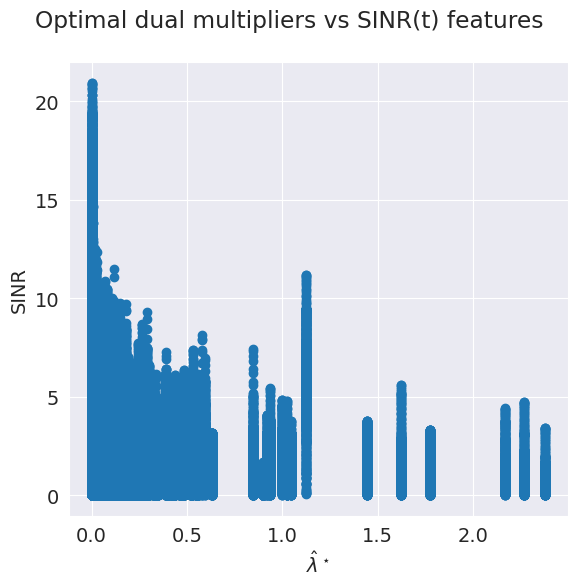

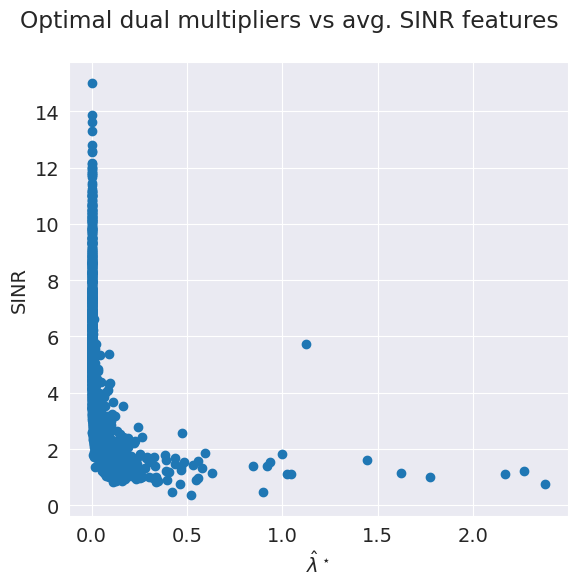

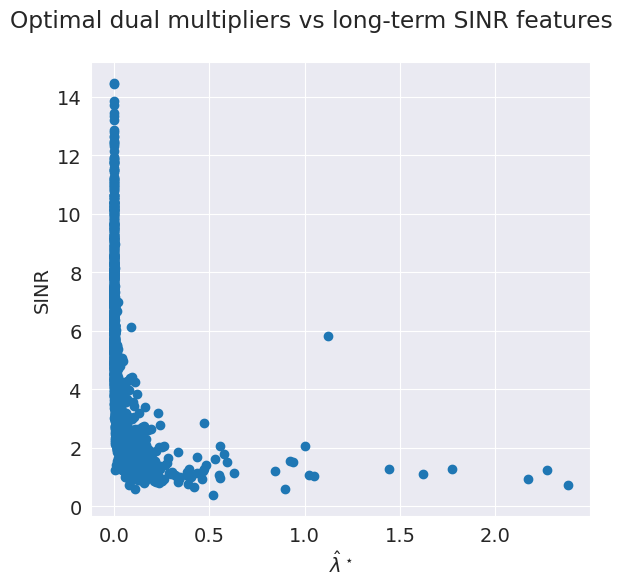

In [44]:
all_log_sinr_features, hl_log_sinr_features = get_log_SINR_features(sa_learner=sa_learner)
print('optimal_lambdas.shape: ', optimal_lambdas.shape)
print('all log SINR features.shape: ', all_log_sinr_features.shape)
print('hl log SINR features.shape: ', hl_log_sinr_features.shape)
scatter_plot_dual_multipliers_sinr_features(lambdas= optimal_lambdas, sinr_features=all_log_sinr_features, title = 'Optimal dual multipliers vs SINR(t) features')
scatter_plot_dual_multipliers_sinr_features(lambdas= optimal_lambdas, sinr_features=all_log_sinr_features.mean(-1, keepdims=True), title = 'Optimal dual multipliers vs avg. SINR features')
scatter_plot_dual_multipliers_sinr_features(lambdas= optimal_lambdas, sinr_features=hl_log_sinr_features, title = 'Optimal dual multipliers vs long-term SINR features')


## Run Test Phase

In [15]:
# Make test configs
test_configs = []  

test_config = copy.deepcopy(args)
test_config.name = 'proportional-slicing'
test_config.slicing_strategy = 'proportional'
# test_config.constraint_rate_violation_rate = constraint_rate_violation_rate
# test_config.test_on_train_data = True
# test_config.dual_test_init_strategy = 'zeros'
test_configs.append(test_config)

test_config = copy.deepcopy(args)
test_config.name = 'uniform-slicing'
test_config.slicing_strategy = 'uniform'
# test_config.constraint_rate_violation_rate = constraint_rate_violation_rate
test_configs.append(test_config)

test_config = copy.deepcopy(args)
test_config.name = 'state-augmented-slicing'
test_config.slicing_strategy = 'state-augmented'
# test_config.test_on_train_data = True
test_config.dual_test_init_strategy = 'zeros'
# test_config.constraint_rate_violation_rate = constraint_rate_violation_rate
test_configs.append(test_config)

In [16]:
print('Testing sa_learner...')
test_metrics_list = []
test_metrics_over_time_list = []
for test_config in test_configs:
    # if test_config.dual_test_init_strategy == 'mean-regression':
    #     test_config.name = 'mean_init'
    # if test_config.dual_test_init_strategy == 'optimal-regression':
    #     test_config.name = 'optimal_init'
    # if test_config.dual_test_init_strategy == 'zeros':
    #     test_config.name = 'zeros_init'
    print(f'Testing {test_config.name}')
    test_metrics = sa_learner.test(epoch=sa_learner.all_epoch_results['test_state', test_config.name][-1].epoch + 1, test_config=test_config) # test metric
    test_metrics_list.append([test_metrics])
    test_metrics_over_time_list.append(test_metrics.metrics_over_slices) # append test metrics over time

Testing sa_learner...
Testing proportional-slicing


100%|██████████| 500/500 [02:37<00:00,  3.18it/s]


Testing uniform-slicing


100%|██████████| 500/500 [02:42<00:00,  3.08it/s]


Testing state-augmented-slicing


100%|██████████| 500/500 [02:46<00:00,  3.00it/s]


## Plot test metrics

In [17]:
print('Plotting test evolution over epochs...')
sa_learner.plot_test_evolution_over_epochs(test_metrics_list,
                                        test_config_names=[_.name for _ in test_configs],
                                        save_path=save_path + subpath + '/plots/test_evolution/',
                                        plot_actual_metrics = True)
            
k_networks = sa_learner.config.num_samples['test']
print('Plotting test evolution over timesteps...')
sa_learner.plot_test_evolution_over_slices(test_metrics_list,
                                            test_config_names = [_.name for _ in test_configs],
                                            save_path=save_path + subpath + '/plots/test_evolution_over_slices/',
                                            network_idx = random.sample(range(sa_learner.config.num_samples['test']), k = min(k_networks, sa_learner.config.num_samples['test'])),
                                            plot_actual_metrics = True)

Plotting test evolution over epochs...
Plotting test evolution over timesteps...


<Figure size 640x480 with 0 Axes>